# Projekt 2
## Datenhandling und Handschriftenerkennung

Wir schauen uns an, wie wir in PyTorch mit Daten umgehen und trainieren ein Neural Net zur Handschriftenerkennung auf dem MNIST Dataset.

In [ ]:
import IPython
import matplotlib
import matplotlib.pyplot as plt
import seaborn

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision

import multiprocessing

In [ ]:
%matplotlib inline

In [ ]:
rand_seed = 83
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

In [ ]:
force_use_cpu = False
if torch.cuda.is_available() and not force_use_cpu:    
    print(f"CUDA device available: {torch.cuda.get_device_name()}")
    use_cuda = True
else:
    print(f"CUDA not available or disabled, using CPU.")
    use_cuda = False
    
cpu_cores = multiprocessing.cpu_count()
print(f"Available CPU cores: {cpu_cores}")

CUDA not available or disabled, using CPU.
Available CPU cores: 2


In [ ]:
dataset_folder = "mnist_dataset"

mnist = torchvision.datasets.MNIST(dataset_folder, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_dataset/MNIST/raw/train-images-idx3-ubyte.gz to mnist_dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_dataset/MNIST/raw



In [ ]:
mean = mnist.data.type(torch.FloatTensor).reshape(-1).div(255.).mean()
std_dev = mnist.data.type(torch.FloatTensor).reshape(-1).div(255.).var().sqrt()

In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,), (std_dev,))
])

train_dataset = torchvision.datasets.MNIST(dataset_folder, train = True, transform = transforms)
test_dataset = torchvision.datasets.MNIST(dataset_folder, train = False, transform = transforms)


In [ ]:
batch_size = 4096

num_workers = cpu_cores//2

pin_memory = use_cuda

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          pin_memory=pin_memory,
                                          num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          pin_memory=pin_memory, 
                                          num_workers=num_workers)

In [ ]:
small_dataset_size = 4096
small_dataset, _ = torch.utils.data.random_split(train_dataset, lengths=[small_dataset_size, len(train_dataset)-small_dataset_size])
len(small_dataset)

4096

In [ ]:
test_train_loader = torch.utils.data.DataLoader(small_dataset, batch_size=4096, shuffle=True, pin_memory=True)

In [ ]:
def select_device(use_cuda=True):
    use_cuda = use_cuda and torch.cuda.is_available()
    name = 'cuda:0' if use_cuda else 'cpu'
    return torch.device(name)
device = select_device()

## Projektaufgaben
1. Es kommt häufiger vor, dass man mehrdimensionale Daten "flachmachen", also in einen eindimensionalen Tensor umwandeln muss. Implementieren Sie diese Funktionalität als PyTorch-Modul, sodass Sie sie später wiederverwenden können. Vergessen Sie nicht, dass bei zweidimensionalen Bilddaten der Input-Tensor vierdimensional sein kann, da die erste Dimension eventuell der Batch-Index und die zweite der Farbkanal ist. In diesem Fall dürfen nur die letzten drei Dimensionen zusammengefasst werden. Eventuell finden Sie ein hilfreiches Modul in der [PyTorch Dokumentation](https://pytorch.org/docs/stable/nn.html)...
2. MNIST ist ein Klassifizierungsproblem. Es bietet sich also an, eine *Accuracy*-Metrik zu implementieren: Schreiben Sie eine Funktion, die als Input eine Batch an Labels und eine Batch an Predictions erhält und darauf den Anteil an korrekt klassifizierten Beispielen berechnet. Integrieren Sie die Funktion in den Trainingsloop, sodass Ihnen nicht nur der Trainings- und Validation-Loss sondern auch die Trainings- und Validation-Accuracy angezeigt wird. Ihre Implementierung sollte keine Schleifen enthalten, sondern auf Tensoroperationen basieren. Tipp: Eine Übersicht aller Tensoroperationen finden Sie [hier](https://pytorch.org/docs/stable/tensors.html#tensor-class-reference).
3. Bauen Sie ein MLP für MNIST als PyTorch-Modul. Nutzen Sie dabei Ihr Modul aus Aufgabe 1. und die typischen Bausteine aus `torch.nn`.
4. Trainieren Sie das MLP aus 3. auf MNIST und experimentieren Sie mit verschiedenen Hyperparametern und Netzwerkstrukturen. Beispielsweise:
    - Anzahl der Hidden Layer
    - Anzahl der Hidden Neurons
    - Aktivierungsfunktion (ReLu, ElU, Sigmoid)
    - Last-Layer-Aktivierungsfunktion
    - Loss-Funktion
    - Optimierungsmethode
    - Learning Rate
5. Finden Sie einen eigenen Datensatz Ihrer Wahl ([Kaggle](https://www.kaggle.com/datasets) o.Ä. ist als Quelle in Ordnung), implementieren Sie gegebenenfalls ein eigenes `Dataset` und versuchen Sie mithilfe des Gelernten aus den vorherigen Aufgaben ein möglichst gutes MLP zu trainieren.

Bitte fassen Sie Ihre Lösungen in einem eigenen Jupyter-Notebook zusammen!

In [ ]:
class MyFlatten(torch.nn.Module):
    def __init__(self, keep_first = False):
        super().__init__()
        self.keep_first = keep_first
    
    def forward(self, x):
        if self.keep_first:
            return torch.reshape(x, (x.size()[0], -1))
        else:
            return torch.reshape(x, (-1, ))

In [ ]:
batch_size=4096
test_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          pin_memory=pin_memory,
                                          num_workers=num_workers)
example = iter(train_loader).next()

print(example[0].shape)
print(example[1])
x = example[0]
test_batch_size = x.size(0)
x = x.reshape(test_batch_size, -1)
print(x.shape)

flatten = MyFlatten(keep_first = True)
print(flatten.forward(example[0]).shape)

torch.Size([4096, 1, 28, 28])
tensor([5, 0, 4,  ..., 9, 3, 9])
torch.Size([4096, 784])
torch.Size([4096, 784])


### Aufgabe 2

In [ ]:
def calculate_accuracy(x, y):
    assert(x.size() == y.size())
    assert(x.nelement() == x.size(0))
    return sum(1 for x, y in zip(x, y) if x == y) / x.size(0)

#Alternativen:
    #return len(x[x == y])/torch.numel(y), sum(1 for x, y in zip(x, y) if x == y) / x.size(0)
    #return sum(1 for x, y in zip(x, y) if x == y) / x.size(0)

In [ ]:
x = torch.Tensor([1,2,3])
y = torch.Tensor([2,2,3])
y_2 = torch.Tensor([1,2,3])
calculate_accuracy(x, y), calculate_accuracy(x, y_2)

(0.6666666666666666, 1.0)

In [ ]:
def train_and_validate(model, tl, vl, epochs, optim, loss_func, log_interval=1, one_hot=False, **kwargs):
    
    mean = lambda x: torch.mean(torch.Tensor(x))
    
    train_losses_final = []
    train_accuracies_final = []
    val_losses_final = []
    val_accuracies_final = []
    for epoch in range(1, epochs+1):
        
        model.train()
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        for inputs, labels in tl:
            
            optim.zero_grad()
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            pred = model.forward(inputs)
            accuracy = calculate_accuracy(pred.argmax(dim=1), labels)
            train_accuracies.append(accuracy)
            if one_hot:
                labels = F.one_hot(labels)
            loss = loss_func(pred, labels)
            train_losses.append(loss)
            loss.backward()
            optim.step()
            

        if epoch % log_interval == 0:
            print(f"Epoch {epoch}")
            #print(f"{model._parameters}\n")
            print(f"Average training loss: {mean(train_losses)}")
            print(f"Average training accuracy: {mean(train_accuracies)}")            
            with torch.no_grad():
                model.eval() # Model in den Evaluations-/Inferenz-Modus setzen.
                for inputs, labels in vl:
                    if use_cuda:
                        inputs, labels = inputs.cuda(), labels.cuda()
                    pred = model.forward(inputs)
                    accuracy = calculate_accuracy(pred.argmax(dim=1), labels)
                    val_accuracies.append(accuracy)
                    if one_hot:
                        labels = F.one_hot(labels).float()
                    loss = loss_func(pred, labels)
                    val_losses.append(loss)
                    
                    
            print(f"Average validation loss: {mean(val_losses)}")
            print(f"Average validation accuracy: {mean(val_accuracies)}")
            print("----------------------------\n")
            val_accuracies_final.append(mean(val_accuracies))
            val_losses_final.append(mean(val_losses))
            train_accuracies_final.append(mean(train_accuracies))
            train_losses_final.append(mean(train_losses))
            
    return train_losses_final, train_accuracies_final, val_losses_final, val_accuracies_final

In [ ]:
a = torch.Tensor([0,1,2,1,0]).long()
F.one_hot(a)

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]])

In [ ]:
loss_func = F.cross_entropy
epochs = 5
model = MNISTLinear()
optim = torch.optim.Adam(params=model.parameters(), lr=0.01)
if use_cuda:
    model = model.cuda()
    
train_and_validate(model, train_loader, test_loader, epochs=50, optim=optim, loss_func=loss_func, log_interval=10)

In [ ]:
def show_multiple_predictions(model, test_dataset, x_samples=3, y_samples=3):
    num_samples = x_samples*y_samples

    random_indices = (np.random.random_sample(num_samples) * len(test_dataset)).astype(int)

    fig, axes = plt.subplots(x_samples, y_samples, figsize=(15,15))
    flat_axes = np.ravel(axes)


    with torch.no_grad():
        for i, index in enumerate(random_indices):
            prediction = inference(model, test_dataset[index][0])
            flat_axes[i].imshow(test_dataset.data[index])
            flat_axes[i].set_title(f"{prediction.argmax()}")
            flat_axes[i].set_xticks([])
            flat_axes[i].set_yticks([])

In [ ]:
def inference(model, data):
    with torch.no_grad():
        model.eval()
        if use_cuda:
            prediction = model.forward(data.cuda())
        else:
            prediction = model.forward(data)
        return prediction

In [ ]:
show_multiple_predictions(model, test_dataset)

### Aufgabe 3

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, start_dim = 784, num_hidden_units=30, hidden_layers=1, act_fn=nn.ReLU(), last_layer = torch.nn.Identity()): 
        super().__init__()
        self.flatten = MyFlatten(keep_first = True)
        # self.model = torch.nn.Sequential(
        #     torch.nn.Linear(in_features=start_dim, out_features=100),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(in_features=100, out_features=50, bias=True),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(in_features=50, out_features=10, bias=True),
        #     last_layer,
        #     )
        
        self.act_fn = act_fn
        self.last_act_fn = last_layer

        #input layer
        self.layers = nn.ModuleList([nn.Linear(start_dim, num_hidden_units)])

        #hidden layers
        for i in range(hidden_layers):
            self.layers.append(nn.Linear(num_hidden_units, num_hidden_units))


        #output layer
        self.output_layer = nn.Linear(num_hidden_units, 10)

        
    def forward(self, x):

        x = self.flatten(x)

        for module in self.layers:
            x = self.act_fn(module(x))

        x = self.last_act_fn(self.output_layer(x))
        return x

In [ ]:
## LUKAS PART

act_functions = [
    torch.nn.ReLU(),
    torch.nn.ELU(),
    torch.nn.Sigmoid(),
    torch.nn.Tanh()
]

learning_rates = [
    1,
    0.1,
    0.01,
    0.001,
    0.0001,
]

params_list = []
output_list = []

# for lr in learning_rates:
#     epochs = 1
#     model = MLP().to(device)
#     optim = torch.optim.SGD(params=model.parameters(), lr=lr)
#     loss_func = torch.nn.CrossEntropyLoss()
#     params = dict(epochs=epochs, model=model, optim=optim, loss_func=loss_func, lr=lr,
#                   tl=train_loader, vl=test_loader)
#     output = train_and_validate(**params)
#     params_list.append(params)
#     output_list.append(output)

for act_func in act_functions:
    for output_act_func in [act_func, None]:
        if not output_act_func:
            output_act_func = nn.Identity()

        lr = 0.01
        epochs = 1
        model = MLP(last_layer=output_act_func, act_fn = act_func).to(device)
        optim = torch.optim.SGD(params=model.parameters(), lr=lr)
        loss_func = torch.nn.CrossEntropyLoss()
        params = dict(epochs=epochs, model=model, optim=optim, loss_func=loss_func, lr=lr,
                      tl=train_loader, vl=test_loader, act_func=act_func, output_act_func=output_act_func)
        output = train_and_validate(**params)
        params_list.append(params)
        output_list.append(output)

print("Done.")

Epoch 1
Average training loss: 2.2953379154205322
Average training accuracy: 0.12426228821277618
Average validation loss: 2.2905752658843994
Average validation accuracy: 0.13823039829730988
----------------------------

Epoch 1
Average training loss: 2.2876346111297607
Average training accuracy: 0.12373027950525284
Average validation loss: 2.2679331302642822
Average validation accuracy: 0.1650930792093277
----------------------------

Epoch 1
Average training loss: 2.2644155025482178
Average training accuracy: 0.13890503346920013
Average validation loss: 2.2151455879211426
Average validation accuracy: 0.21448653936386108
----------------------------

Epoch 1
Average training loss: 2.2172179222106934
Average training accuracy: 0.23833712935447693
Average validation loss: 2.143775224685669
Average validation accuracy: 0.3667510747909546
----------------------------

Epoch 1
Average training loss: 2.30491042137146
Average training accuracy: 0.09024437516927719
Average validation loss: 2.3

In [ ]:
# LUKAS PLOT
num = len(params_list)
fig = plt.figure(figsize = (11, 11 * num / 2))

for i, (params, output) in enumerate(zip(params_list, output_list)):
    plt.subplot(num, 2, 2 * i + 1)
    plt.plot(output[0], linestyle = '--', marker = 'o', label = 'train loss', c = 'r')
    plt.plot(output[2], linestyle = '--', marker = 'o', label = 'validation loss', c = 'g')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    lr = f'lr: {params["lr"]}'
    act_func = f'act_func: {params["act_func"].__name__ if params["act_func"] else None}'
    output_act_func = f'output_act_func: {params["output_act_func"].__name__ if params["output_act_func"] else None}'
    plt.title(', '.join([lr, act_func, output_act_func]))
    plt.legend()

    plt.subplot(num, 2, 2 * i + 2)
    plt.plot(output[1], linestyle = '--', marker = 'o', label = 'train accuracy', c = 'r')
    plt.plot(output[3], linestyle = '--', marker = 'o', label = 'validation accuracy', c = 'g')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    lr = f'lr: {params["lr"]}'
    act_func = f'act_func: {params["act_func"].__name__ if params["act_func"] else None}'
    output_act_func = f'output_act_func: {params["output_act_func"].__name__ if params["output_act_func"] else None}'
    plt.title(', '.join([lr, act_func, output_act_func]))
    plt.legend()

plt.savefig('result_l1.png')
plt.show()

ValueError: ignored

In [ ]:
my_model = MLP()
loss_functions = [
    F.l1_loss,
    F.soft_margin_loss, # one hot 
    F.nll_loss, # LogSoftmax  als last layer
    F.cross_entropy,
]

one_hot_enabled = [
    True,
    True,
    False,
    False
]

optim_functions = [
    torch.optim.Adam,
    torch.optim.SGD,
    torch.optim.Adagrad,
]


In [ ]:
params_list = []
output_list = []


for loss_func, one_hot in zip(loss_functions, one_hot_enabled):
    for optim in optim_functions:
        print("------------------------------------------------------")
        print(optim, loss_func)
        
        lr = 0.01
        epochs = 2
        if optim == torch.optim.Adam:
            model = MLP(last_layer = torch.nn.LogSoftmax())
        else:
            model = MLP()
        optim = optim(params=model.parameters(), lr=0.01)
        params = dict(model=model, tl=train_loader, vl=test_loader, epochs=epochs, optim=optim, loss_func=loss_func, lr=lr, one_hot=one_hot)
        output = train_and_validate(**params)
        params_list.append(params)
        output_list.append(output)

print("Done.")

------------------------------------------------------
<class 'torch.optim.adam.Adam'> <function l1_loss at 0x7f4e59585a60>


<ipython-input-41-72ca23b246f2>:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last_act_fn(self.output_layer(x))


Epoch 1
Average training loss: 2.412946939468384
Average training accuracy: 0.06959734112024307
Average validation loss: 2.403057098388672
Average validation accuracy: 0.0879460796713829
----------------------------



KeyboardInterrupt: ignored

In [ ]:
num = len(params_list)
fig = plt.figure(figsize = (11, 11 * num / 2))

for i, (params, output) in enumerate(zip(params_list, output_list)):
    plt.subplot(num, 2, 2 * i + 1)
    plt.plot(output[0], linestyle = '--', marker = 'o', label = 'train loss', c = 'r')
    plt.plot(output[2], linestyle = '--', marker = 'o', label = 'validation loss', c = 'g')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    lr = f'lr: {params["lr"]}'
    loss_func = f'loss_func: {params["loss_func"].__name__ if params["loss_func"] else None}'
    optim = f'optim: {params["optim"].__class__.__name__ if params["optim"] else None}'
    plt.title(', '.join([lr, loss_func, optim]))
    plt.legend()

    plt.subplot(num, 2, 2 * i + 2)
    plt.plot(output[1], linestyle = '--', marker = 'o', label = 'train accuracy', c = 'r')
    plt.plot(output[3], linestyle = '--', marker = 'o', label = 'validation accuracy', c = 'g')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    lr = f'lr: {params["lr"]}'
    loss_func = f'loss_func: {params["loss_func"].__name__ if params["loss_func"] else None}'
    optim = f'optim: {params["optim"].__class__.__name__ if params["optim"] else None}'
    plt.title(', '.join([lr, loss_func, optim]))
    plt.legend()
    
plt.savefig('result_2.png')
plt.show()


## Changing number of hidden layers to [1, 3, 5, 7]

In [ ]:
########################
## Hidden Layers = 1 ##
########################

mlpModel1 = MLP()
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=mlpModel1.parameters(), lr=lr)
losses_1_layers, val_loss_1_layers, acc_train_1_layers, acc_val_1_layers = train_and_validate(mlpModel1, train_loader, test_loader, epochs, optim, loss_func, True)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4e58d694c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 1
Average training loss: 1.2465806007385254
Average training accuracy: 0.58024662733078
Average validation loss: 0.48853445053100586
Average validation accuracy: 0.8529064059257507
----------------------------



KeyboardInterrupt: ignored

In [ ]:
########################
## Hidden Layers = 3 ##
########################

mlpModel3 = MLP(num_hidden_units=30, hidden_layers=3)
optim = torch.optim.Adam(params=mlpModel3.parameters(), lr=lr)
losses_3_layers, val_loss_3_layers, acc_train_3_layers, acc_val_3_layers = train_and_validate(mlpModel3, train_loader, test_loader, epochs, optim, loss_func)

Epoch 1
Average training loss: 1.606240153312683
Average training accuracy: 0.4438362717628479


KeyboardInterrupt: ignored

In [ ]:
########################
## Hidden Layers = 5 ##
########################

mlpModel5 = MLP(num_hidden_units=30,  hidden_layers=5)
optim = torch.optim.Adam(params=mlpModel5.parameters(), lr=lr)
losses_5_layers, val_loss_5_layers, acc_train_5_layers, acc_val_5_layers = train_and_validate(mlpModel5, train_loader, test_loader, epochs, optim, loss_func)

In [ ]:
########################
## Hidden Layers = 7 ##
########################

mlpModel7 = MLP(num_hidden_units=30,  hidden_layers=7)
optim = torch.optim.Adam(params=mlpModel7.parameters(), lr=lr)
losses_7_layers, val_loss_7_layers, acc_train_7_layers, acc_val_7_layers = train_and_validate(mlpModel7, train_loader, test_loader, epochs, optim, loss_func)

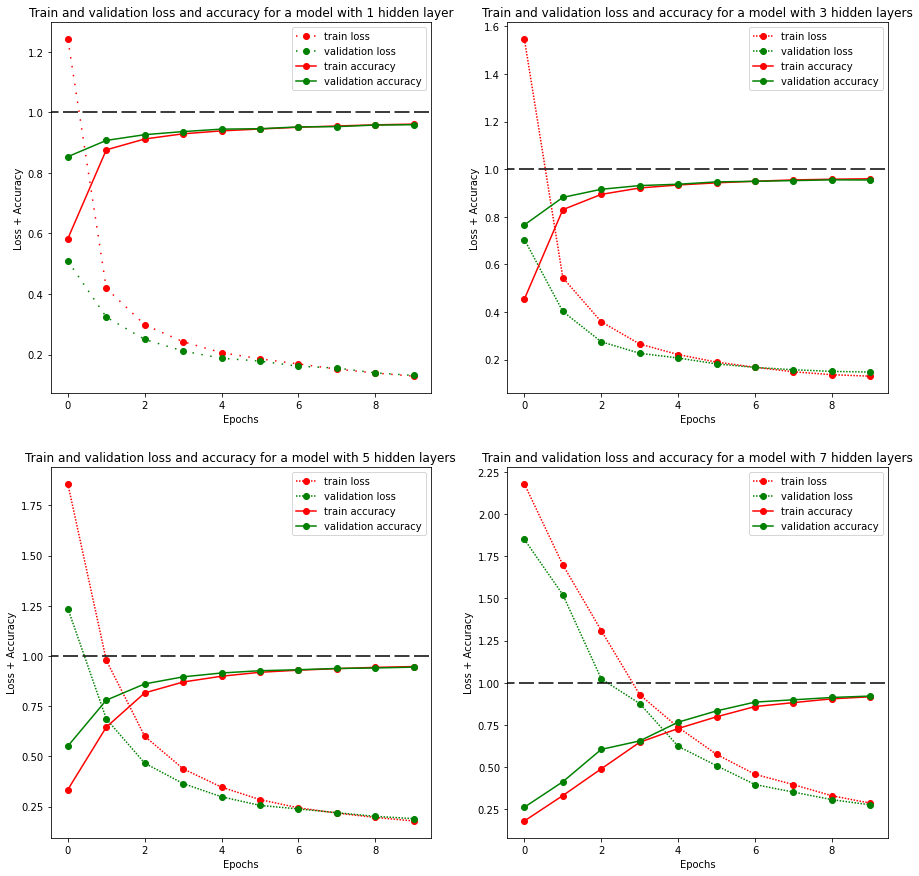

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15,15)) 
axs[0,0].plot(losses_1_layers, linestyle = (0, (1, 5)), marker = 'o', label = 'train loss', c = 'r')
axs[0,0].plot(val_loss_1_layers, linestyle = (0, (1, 5)), marker = 'o', label = 'validation loss', c = 'g')
axs[0,0].plot(acc_train_1_layers, linestyle = '-', marker = 'o', label = 'train accuracy', c = 'r')
axs[0,0].plot(acc_val_1_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[0,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss + Accuracy")
axs[0,0].set_title("Train and validation loss and accuracy for a model with 1 hidden layer")
axs[0,0].legend()

axs[0,1].plot(losses_3_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[0,1].plot(val_loss_3_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[0,1].plot(acc_train_3_layers, linestyle = '-', marker = 'o', label = 'train accuracy', c = 'r')
axs[0,1].plot(acc_val_3_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[0,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Loss + Accuracy")
axs[0,1].set_title("Train and validation loss and accuracy for a model with 3 hidden layers")
axs[0,1].legend()

axs[1,0].plot(losses_5_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,0].plot(val_loss_5_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[1,0].plot(acc_train_5_layers, linestyle = '-', marker = 'o', label = 'train accuracy', c = 'r')
axs[1,0].plot(acc_val_5_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[1,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss + Accuracy")
axs[1,0].set_title("Train and validation loss and accuracy for a model with 5 hidden layers")
axs[1,0].legend()

axs[1,1].plot(losses_7_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,1].plot(val_loss_7_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[1,1].plot(acc_train_7_layers, linestyle = '-', marker = 'o', label = 'train accuracy', c = 'r')
axs[1,1].plot(acc_val_7_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[1,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Loss + Accuracy")
axs[1,1].set_title("Train and validation loss and accuracy for a model with 7 hidden layers")
axs[1,1].legend()


## Changing number of Hidden units per layer to [30, 60, 128, 256]

In [ ]:
############################
## Number of Neurons = 30 ##
############################

mlpModel30 = MLP(30)
optim = torch.optim.Adam(params=mlpModel30.parameters(), lr=lr)
losses_30n, val_loss_30n, acc_30n, val_acc_30n = train_and_validate(mlpModel30, train_loader, test_loader, epochs, optim, loss_func)

In [ ]:
############################
## Number of Neurons = 60 ##
############################

mlpModel60 = MLP(num_hidden_units=60)
optim = torch.optim.Adam(params=mlpModel60.parameters(), lr=lr)
losses_60n, val_loss_60n, acc_60n, val_acc_60n = train_and_validate(mlpModel60, train_loader, test_loader, epochs, optim, loss_func)

In [ ]:
############################
## Number of Neurons = 128 ##
############################

mlpModel128 = MLP(num_hidden_units=128)
optim = torch.optim.Adam(params=mlpModel128.parameters(), lr=lr)
losses_128n, val_loss_128n, acc_128n, val_acc_128n = train_and_validate(mlpModel128, train_loader, test_loader, epochs, optim, loss_func)

In [ ]:
############################
## Number of Neurons = 256 ##
############################

mlpModel256 = MLP(num_hidden_units=256)
optim = torch.optim.Adam(params=mlpModel256.parameters(), lr=lr)
losses_256n, val_loss_256n, acc_256n, val_acc_256n = train_and_validate(mlpModel256, train_loader, test_loader, epochs, optim, loss_func)

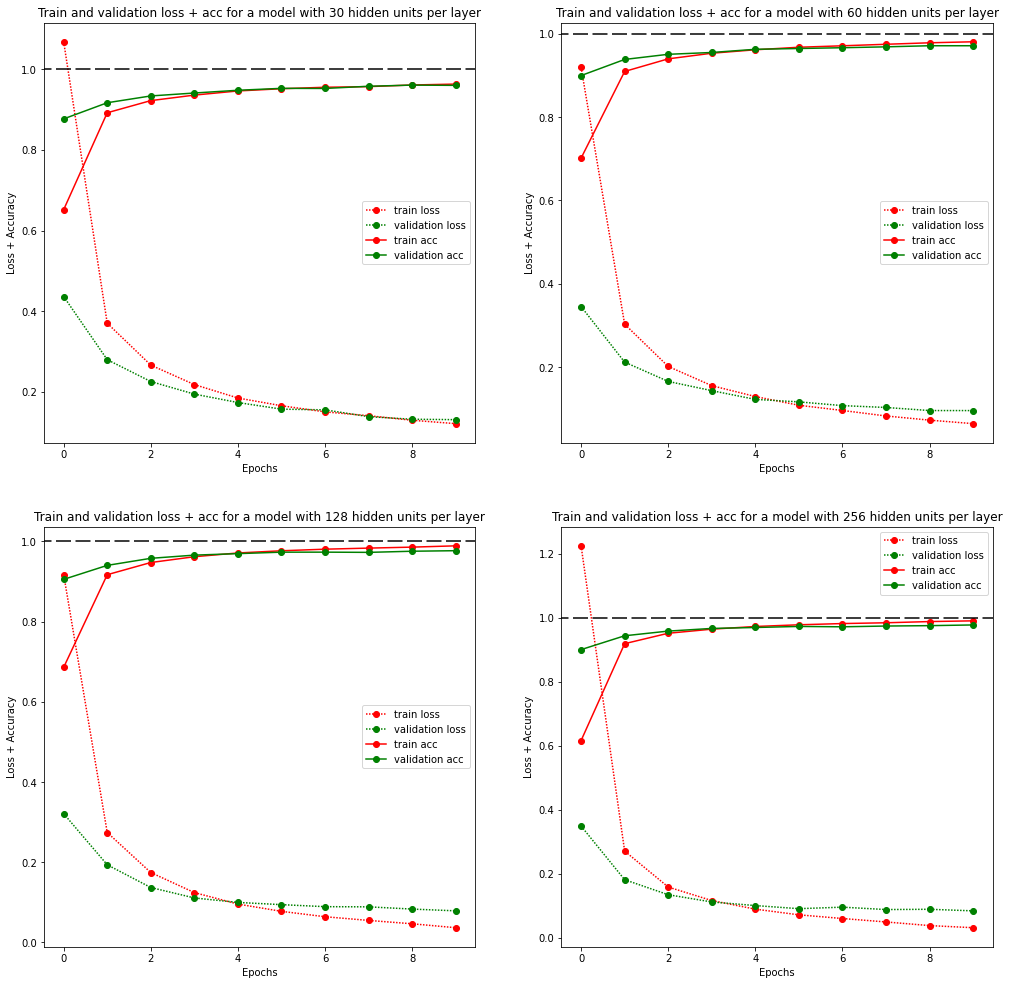

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(17,17))
axs[0,0].plot(losses_30n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[0,0].plot(val_loss_30n, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[0,0].plot(acc_30n, linestyle = '-', marker = 'o', label = 'train acc', c = 'r')
axs[0,0].plot(val_acc_30n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[0,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss + Accuracy")
axs[0,0].set_title("Train and validation loss + acc for a model with 30 hidden units per layer")
axs[0,0].legend()

axs[0,1].plot(losses_60n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[0,1].plot(val_loss_60n, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[0,1].plot(acc_60n, linestyle = '-', marker = 'o', label = 'train acc', c = 'r')
axs[0,1].plot(val_acc_60n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[0,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Loss + Accuracy")
axs[0,1].set_title("Train and validation loss + acc for a model with 60 hidden units per layer")
axs[0,1].legend()

axs[1,0].plot(losses_128n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,0].plot(val_loss_128n, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[1,0].plot(acc_128n, linestyle = '-', marker = 'o', label = 'train acc', c = 'r')
axs[1,0].plot(val_acc_128n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[1,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss + Accuracy")
axs[1,0].set_title("Train and validation loss + acc for a model with 128 hidden units per layer")
axs[1,0].legend()

axs[1,1].plot(losses_256n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,1].plot(val_loss_256n, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[1,1].plot(acc_256n, linestyle = '-', marker = 'o', label = 'train acc', c = 'r')
axs[1,1].plot(val_acc_256n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[1,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Loss + Accuracy")
axs[1,1].set_title("Train and validation loss + acc for a model with 256 hidden units per layer")
axs[1,1].legend()

plt.savefig("hidden_units")
plt.show()

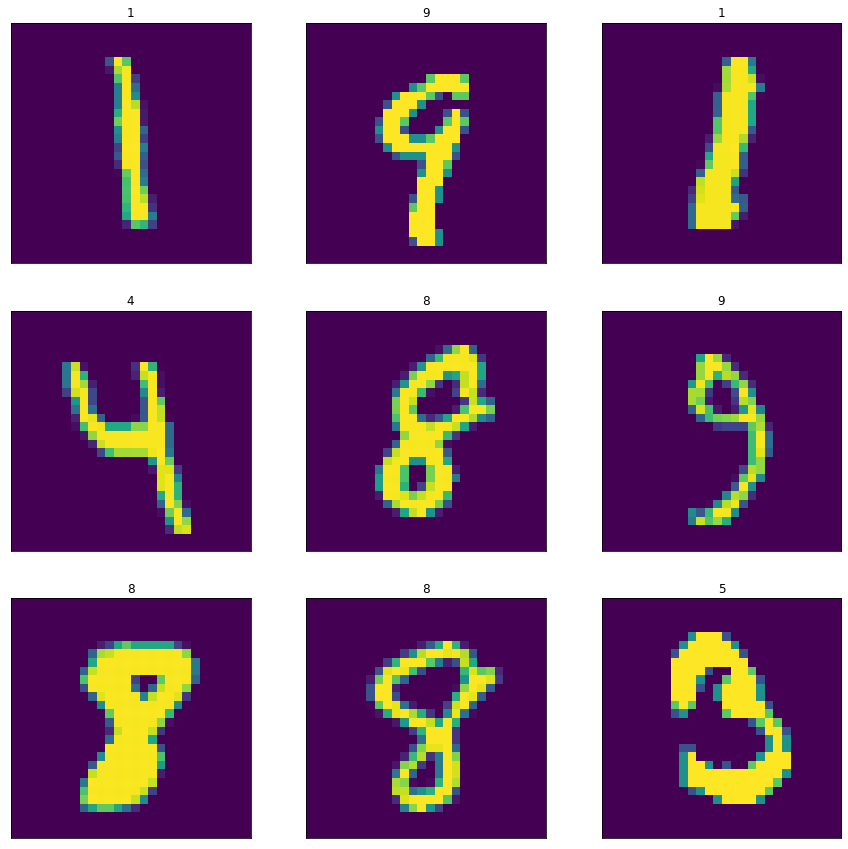

In [ ]:
show_multiple_predictions(mlpModel1, test_dataset) 

### Aufgabe 5

In [55]:
import glob
import os
from PIL import Image

In [57]:
main_path = "./chest_xray"
data_normal = glob.glob(main_path+"/**/NORMAL*.jpeg", recursive=True)
data_virus = glob.glob(main_path+"/**/VIRUS*.jpeg", recursive=True)
data_bacteria = glob.glob(main_path+"/**/BACTERIA*.jpeg", recursive=True)
data_bacteria[:5]

[]

In [58]:
def loaders_from_ds(ds, split=0.8, batch_size=32):
    train_set_size = int(split * len(ds))
    val_set_size = len(ds) - train_set_size
    ts, vs = torch.utils.data.random_split(ds, lengths=[train_set_size, val_set_size])
    
    train_loader = torch.utils.data.DataLoader(ts, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(vs, batch_size=batch_size, shuffle=True)
    
    return train_loader, val_loader

In [59]:
class TrainDataSet(torch.utils.data.Dataset):
    def __init__(self, *args, **kwargs):
        super().__init__()
        main_path = "./chest_xray"
        data_normal = glob.glob(main_path+"/**/NORMAL*.jpeg", recursive=True)
        data_virus = glob.glob(main_path+"/**/VIRUS*.jpeg", recursive=True)
        data_bacteria = glob.glob(main_path+"/**/BACTERIA*.jpeg", recursive=True)
        self.data = pd.DataFrame(np.concatenate([['NORMAL'] * len(data_normal), ['VIRUS'] * len(data_virus), ['BACTERIA'] * len(data_bacteria)]), columns = ['class'])
        data_all = []
        data_all.extend(data_normal)
        data_all.extend(data_virus)
        data_all.extend(data_bacteria)
        self.data['image'] = data_all
        self.class_to_idx = {'NORMAL': 0, 'VIRUS': 1, 'BACTERIA': 2}
        self.classes = {v: k for k, v in self.class_to_idx.items()}
        
    def __getitem__(self, index):
        x = self.data['image'][index]
        y = self.data['class'][index]
        y = self.class_to_idx[y]
        with Image.open(x) as x2:
            x2 = x2.resize((200, 200), Image.Resampling.LANCZOS)
            x2 = x2.convert('L')
            x2 = torchvision.transforms.ToTensor()(x2)
        return x2, y
    
    def __len__(self):
        return len(self.data)

In [60]:
def select_device(use_cuda=True):
    use_cuda = use_cuda and torch.cuda.is_available()
    name = 'cuda:0' if use_cuda else 'cpu'
    return torch.device(name)

def loaders_from_dataset(dataset, device, split=0.8, batch_size=256):
    ''' This might look redundant, but allows the data to always be on the gpu. '''
    tn = int(split * len(dataset))
    vn = len(dataset) - tn
    ts, vs = torch.utils.data.random_split(dataset, lengths=[tn, vn])
    tl = torch.utils.data.DataLoader(ts, shuffle=True, batch_size=len(ts))
    vl = torch.utils.data.DataLoader(vs, shuffle=False, batch_size=len(vs))
    _, (tx, ty) = next(enumerate(tl))
    _, (vx, vy) = next(enumerate(vl))    
    ts = torch.utils.data.TensorDataset(tx.to(device), ty.to(device)) 
    vs = torch.utils.data.TensorDataset(vx.to(device), vy.to(device))
    params = dict(batch_size=batch_size)
    tl = torch.utils.data.DataLoader(ts, shuffle=True, **params)
    vl = torch.utils.data.DataLoader(vs, shuffle=False, **params)
    return tl, vl

In [61]:
ds = TrainDataSet()
tl, vl = loaders_from_dataset(ds, batch_size=256, device=select_device())
test_batch = next(iter(tl))

ValueError: ignored

In [ ]:
test_batch[0][0].size(), test_batch[1][0], test_batch[0][0][0,100:200,100:200]

(torch.Size([1, 400, 400]),
 tensor(0),
 tensor([[0.4431, 0.4353, 0.4588,  ..., 0.6118, 0.5765, 0.5961],
         [0.4275, 0.4353, 0.4627,  ..., 0.6235, 0.6000, 0.6078],
         [0.4314, 0.4471, 0.4510,  ..., 0.6157, 0.6078, 0.6000],
         ...,
         [0.3922, 0.4157, 0.4471,  ..., 0.5490, 0.5608, 0.5647],
         [0.4784, 0.5020, 0.5333,  ..., 0.5529, 0.5451, 0.5569],
         [0.5529, 0.5843, 0.6118,  ..., 0.5294, 0.5255, 0.5569]]))

In [54]:
lr = 0.01
epochs = 30
model = MLP(start_dim = 200 * 200, num_hidden_units = 256, hidden_layers = 20)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
loss_func = F.cross_entropy
params = dict(model=model, tl=tl, vl=vl, epochs=epochs, optim=optim, loss_func=loss_func, lr=lr)
output = train_and_validate(**params)


NameError: ignored

In [ ]:
model(test_batch[0])

tensor([[-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
        [-0.3019, -0.3656,  0.2667],
 